In [337]:
from utils.sdrf import sdrf
from utils import fosr

import utils.data_loader as loader
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import torch

import utils.torch_resistance_metrics as ermet
import utils.data_loader as loader
import copy
from torch_geometric.data import Data
from utils.GraphWrapper import GraphWrapper
import networkx as nx
import matplotlib.pyplot as plt

In [338]:
N_LINKS = 2
TAU = 1000
GRAPH = ['lollipop', 'cat', 'SBM', 'PLBottle', 'PLDense', 'Barbell'][4]

In [339]:

if GRAPH == 'lollipop':
    G = nx. lollipop_graph(4, 5) 
    pos= nx.kamada_kawai_layout(G)
    NODE_SIZE = 300

elif GRAPH == 'cat':
    G = nx.Graph()
    G.add_edges_from([(0,1),(0,3),(1,2),(1,3),(1,4),(2,4),(2,11),(3,4),(3,5),
                    (4,5),(5,6),(5,7),(6,7),(6,8),(6,9), (7,9),(7,10),(8,9),
                    (9,10),(10,15),(11,12),(13,14),(14,15),(0,11),(8,15),
                    (13,12) 
                    ])
    pos= nx.kamada_kawai_layout(G)
    G.remove_edge(13,12)
    NODE_SIZE=300
elif GRAPH == 'SBM':
    NODE_SIZE = 100
    NCC=0
    while NCC!=1:
        G = nx.stochastic_block_model([25,25], [[0.3, 0.01], [0.01, 0.3]], seed=42)
        NCC = nx.number_connected_components(G)
    pos= nx.kamada_kawai_layout(G)

elif GRAPH == 'PLBottle':
    G = nx.powerlaw_cluster_graph(50, 2, .95,seed=42)
    pos= nx.kamada_kawai_layout(G)
    NODE_SIZE=80
elif GRAPH == 'PLDense':
    G = nx.powerlaw_cluster_graph(50, 2, .8,seed=42)
    pos= nx.kamada_kawai_layout(G)
    NODE_SIZE=80
elif GRAPH == 'Barbell':

    G = nx.Graph()
    G.add_edges_from([(0,1),(1,2),(2,7),
                      (7,8), (8,9), (8,10), (8,11), (9,10), (9,11), (10,11),
                      (0,12), (12,13), (12,14), (15,12), (13,14), (13,15), (14,15),
                      
                    ])
    G = nx.relabel_nodes(G, {node: i for i,node in enumerate(G.nodes)}, copy=True)
    pos= nx.kamada_kawai_layout(G)
    NODE_SIZE=100
    
else:
    raise ValueError('Invalid graph type')

In [340]:
#Rename nodes from 0 to Number of nodes
G.number_of_nodes()

50

In [341]:
edge_list = np.array(G.edges())
edge_list = torch.Tensor(np.hstack((edge_list.T, edge_list.T[[1,0],:]))).long()
GW = GraphWrapper(edgelist=edge_list)

Loaded Graph with 50 nodes and 96 edges - L computation mode: exact


In [342]:
def draw_G(G,R,ORI_NODE=None, HL=None, ax=None, d_lims=None):
    er = R
    #er = nx.floyd_warshall_numpy(G, nodelist = sorted(list(G.nodes)))
    color = er[ORI_NODE,:] if ORI_NODE is not None else R.mean(axis=1)
    f, ax = plt.subplots(1, 1, figsize=(4, 3)) if ax is None else ('OUT', ax)
    node_options = {
            "node_size": [NODE_SIZE]*G.number_of_nodes(),
            "node_color": color,
            "cmap": plt.cm.hot_r,
            'pos':pos,
            "alpha": 1,
            "edgecolors": "grey",
            "linewidths": 1,
        }
    edge_options = {
            "width": 2,
            "edge_cmap": plt.cm.seismic,
            "edge_color": 'black',
            'pos':pos,
            "alpha": .5,
        }
    label_options = {
            'pos':pos,
            'font_color':'w',
            'font_size':10,
            'font_weight':'bold',
            'alpha':1
    }

    ordered_nodes_wh_ori = np.arange(G.number_of_nodes())
    if ORI_NODE is not None: node_options['node_size'][ORI_NODE] = 0 
    if d_lims is not None:
        d_min, d_max = d_lims
    else:
        d_min, d_max = color.min(), color.max()

    nx.draw_networkx_nodes(G, nodelist = ordered_nodes_wh_ori, **node_options, ax=ax,
                        vmin = d_min, vmax = d_max,)
    if ORI_NODE is not None:
        nx.draw_networkx_nodes(G, nodelist = [ORI_NODE], pos=pos, node_color='black', ax=ax, node_shape='*')
    nx.draw_networkx_edges(G, **edge_options, ax=ax)
    if HL:
        hl_edges = nx.draw_networkx_edges(G, pos=pos, edgelist=HL, edge_color='lightgreen', ax=ax, width= 3)
        #draw nodes of the HL edges
        #hl_nodes = nx.draw_networkx_nodes(G, nodelist = np.unique(HL), pos=pos,
        #                                  node_color=node_options['node_color'][np.unique(HL)],
        #                                 edgecolors='grey', node_size=300, linewidths= 1, ax=ax)
        hl_edges.set_zorder(20)
        #hl_nodes.set_zorder(21)

    sm = plt.cm.ScalarMappable(cmap=node_options['cmap'], 
                            norm=plt.Normalize(vmin=d_min, vmax=d_max))
    ax.axis('off')
    cbar = plt.colorbar(sm, shrink=.8, aspect=10, ax=ax)
    #ticklabs = cbar.ax.get_yticklabels()
    #cbar.ax.set_yticklabels(ticklabs, fontsize=12)

    if f != 'OUT':
        plt.tight_layout()
        plt.show()

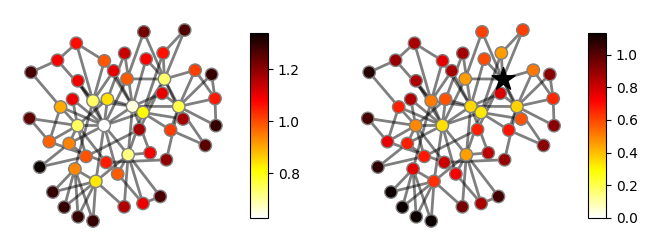

In [343]:
f, axs = plt.subplots(1, 2, figsize=(8, 3))
draw_G(G, R=GW.get_effective_resistance(), ax=axs[0])
draw_G(G, R=GW.get_effective_resistance(),ORI_NODE=8, ax=axs[1])

**SDRF**

In [344]:
GW1, added_links_sdrf = sdrf(copy.deepcopy(GW), loops=N_LINKS, remove_edges=False, removal_bound=2, is_undirected=True, tau=TAU)
G_sdrf = G.copy()
for e in added_links_sdrf:
    G_sdrf.add_edge(e[0],e[1])

100%|██████████| 2/2 [00:00<00:00, 68.92it/s]


In [345]:
added_links_sdrf

[[1, 33], [34, 8]]

**FOSR**

In [346]:
new_edgelist_fosr = fosr.edge_rewire(copy.deepcopy(GW).edgelist.numpy(), num_iterations=N_LINKS, initial_power_iters=10)[0]
# added_links_fosr to list
added_links_fosr = new_edgelist_fosr[:,-N_LINKS*2:].T.tolist()
G_fosr = G.copy()
for e in added_links_fosr:
    G_fosr.add_edge(e[0],e[1])
GW_fosr = GraphWrapper(edgelist=torch.LongTensor(new_edgelist_fosr))
added_links_fosr

Loaded Graph with 50 nodes and 98 edges - L computation mode: exact


[[39, 17], [17, 39], [43, 41], [41, 43]]

ERG

In [347]:
GW_ERG = copy.deepcopy(GW)
G_ERG = G.copy()
added_links_erg = []
for i in range(N_LINKS):
    R = GW_ERG.get_effective_resistance().cpu().detach()
    argmax = (R* GW_ERG.edge_mask.cpu().detach()).argmax().item() #detach and cpu on call
    n = R.shape[0]
    u, v = divmod(argmax, n)    
    if GW_ERG.is_edge(u,v):
        raise Exception('Edge already exists')
    else:
        GW_ERG.add_link(u,v)
        G_ERG.add_edge(u,v)
        added_links_erg.append((u,v))

Cosine

In [348]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix

In [349]:
GW_COS = copy.deepcopy(GW)
G_COS = G.copy()

added_links_cos = []
for i in range(N_LINKS):
    edge_index = GW_COS.edgelist.detach().cpu()
    n = GW_COS.num_nodes
    adj_sparse = coo_matrix((np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])),
                        shape=(n, n))
    cos_sim = cosine_similarity(adj_sparse)

    cos_sim[torch.logical_not(GW_COS.edge_mask.cpu().detach())]=torch.inf
    argmin = cos_sim.argmin().item()
    n = cos_sim.shape[0] if n is None else n
    u, v = divmod(argmin, n)
    
    if GW_COS.is_edge(u,v):
        raise Exception('Edge already exists')
    else:
        GW_COS.add_link(u,v)
        G_COS.add_edge(u,v)
        added_links_cos.append((u,v))

added_links_cos       

[(0, 5), (0, 9)]

## VIZ

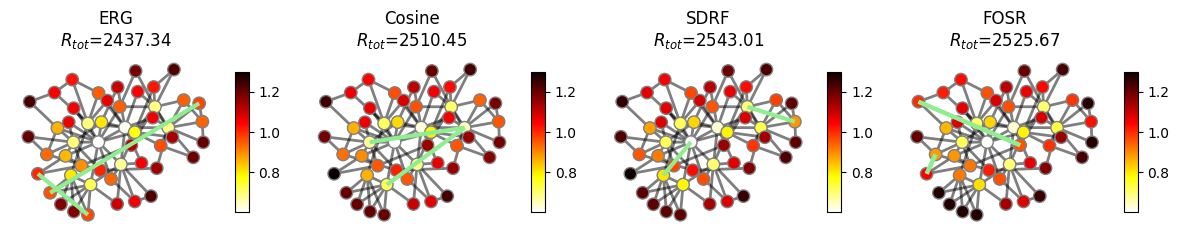

In [351]:
#Create matplotlib subplots, one for each method. Im gonna plot on each subplot the rewired graph with a different method. There are 5 subplots, one for each method.
f, ax = plt.subplots(1, 4, figsize=(12, 2.5))
ax = ax.flatten()

min_rtot = GW_COS.get_effective_resistance().mean(axis=1).min()
max_rtot = GW_COS.get_effective_resistance().mean(axis=1).max()


ax[0].set_title(f'ERG\n$R_{{tot}}$={GW_ERG.get_effective_resistance().sum():.2f}')
draw_G(G_ERG, R=GW_ERG.get_effective_resistance(), ax=ax[0], HL=added_links_erg, d_lims=(min_rtot, max_rtot))

ax[1].set_title(f'Cosine\n$R_{{tot}}$={GW_COS.get_effective_resistance().sum():.2f}')
draw_G(G_COS, R=GW_COS.get_effective_resistance(), ax=ax[1], HL=added_links_cos, d_lims=(min_rtot, max_rtot))

ax[2].set_title(f'SDRF\n$R_{{tot}}$={GW1.get_effective_resistance().sum():.2f}')
draw_G(G_sdrf, R=GW1.get_effective_resistance(), ax=ax[2], HL=added_links_sdrf, d_lims=(min_rtot, max_rtot))

ax[3].set_title(f'FOSR\n$R_{{tot}}$={GW_fosr.get_effective_resistance().sum():.2f}')
draw_G(G_fosr, R=GW_fosr.get_effective_resistance(), ax=ax[3], HL=added_links_fosr, d_lims=(min_rtot, max_rtot))

plt.tight_layout()
plt.show()
#save figure png
f.savefig(f'results/figures/rewired_graphs/rewiring-{GRAPH}-{N_LINKS}.png', dpi=300, bbox_inches='tight', transparent=True, pad_inches=0, format='png')

KeyboardInterrupt: 

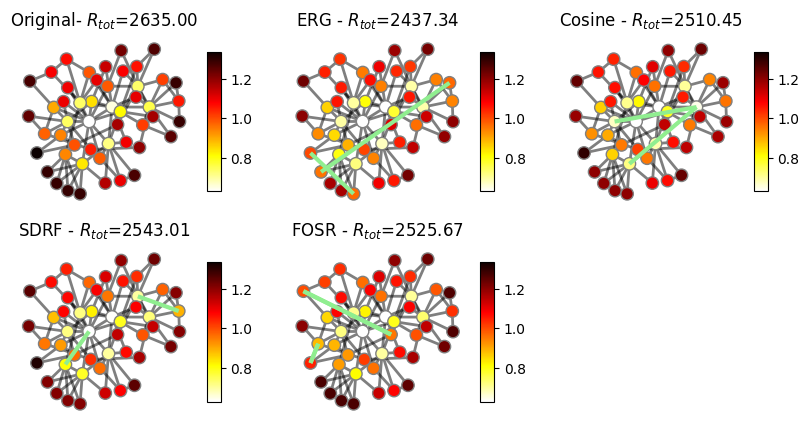

In [352]:
#Create matplotlib subplots, one for each method. Im gonna plot on each subplot the rewired graph with a different method. There are 5 subplots, one for each method.
f, ax = plt.subplots(2, 3, figsize=(10, 5))
ax = ax.flatten()

min_rtot = GW.get_effective_resistance().mean(axis=1).min()
max_rtot = GW.get_effective_resistance().mean(axis=1).max()

ax[0].set_title(f'Original- $R_{{tot}}$={GW.get_effective_resistance().sum():.2f}')
draw_G(G, R=GW.get_effective_resistance(), ax=ax[0], d_lims=(min_rtot, max_rtot))

ax[1].set_title(f'ERG - $R_{{tot}}$={GW_ERG.get_effective_resistance().sum():.2f}')
draw_G(G_ERG, R=GW_ERG.get_effective_resistance(), ax=ax[1], HL=added_links_erg, d_lims=(min_rtot, max_rtot))

ax[2].set_title(f'Cosine - $R_{{tot}}$={GW_COS.get_effective_resistance().sum():.2f}')
draw_G(G_COS, R=GW_COS.get_effective_resistance(), ax=ax[2], HL=added_links_cos, d_lims=(min_rtot, max_rtot))

ax[3].set_title(f'SDRF - $R_{{tot}}$={GW1.get_effective_resistance().sum():.2f}')
draw_G(G_sdrf, R=GW1.get_effective_resistance(), ax=ax[3], HL=added_links_sdrf, d_lims=(min_rtot, max_rtot))

ax[4].set_title(f'FOSR - $R_{{tot}}$={GW_fosr.get_effective_resistance().sum():.2f}')
draw_G(G_fosr, R=GW_fosr.get_effective_resistance(), ax=ax[4], HL=added_links_fosr, d_lims=(min_rtot, max_rtot))

ax[5].axis('off')

plt.tight_layout()
plt.show()

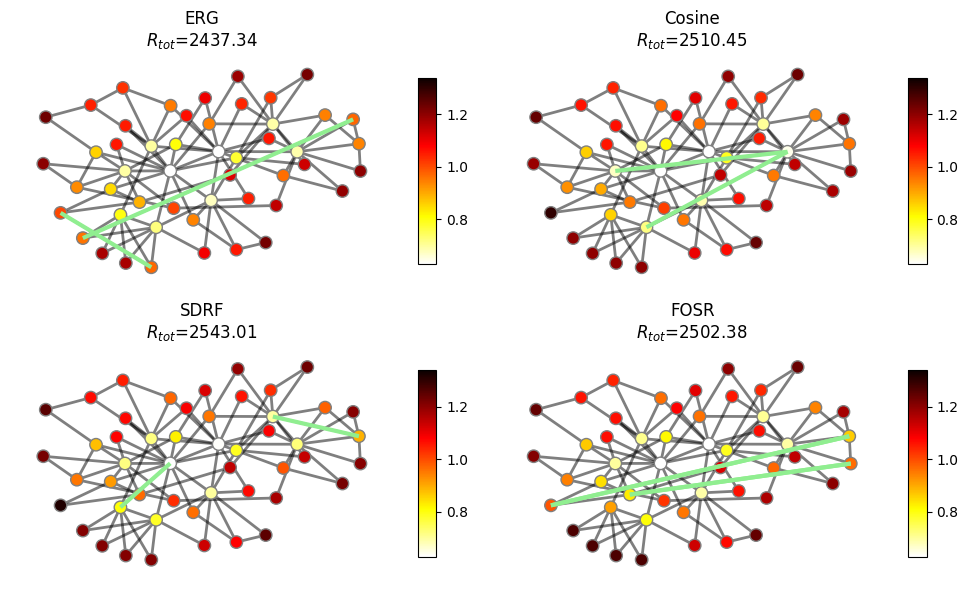

In [ ]:
#Create matplotlib subplots, one for each method. Im gonna plot on each subplot the rewired graph with a different method. There are 5 subplots, one for each method.
f, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.flatten()

min_rtot = GW.get_effective_resistance().mean(axis=1).min()
max_rtot = GW.get_effective_resistance().mean(axis=1).max()


ax[0].set_title(f'ERG\n$R_{{tot}}$={GW_ERG.get_effective_resistance().sum():.2f}')
draw_G(G_ERG, R=GW_ERG.get_effective_resistance(), ax=ax[0], HL=added_links_erg, d_lims=(min_rtot, max_rtot))

ax[1].set_title(f'Cosine\n$R_{{tot}}$={GW_COS.get_effective_resistance().sum():.2f}')
draw_G(G_COS, R=GW_COS.get_effective_resistance(), ax=ax[1], HL=added_links_cos, d_lims=(min_rtot, max_rtot))

ax[2].set_title(f'SDRF\n$R_{{tot}}$={GW1.get_effective_resistance().sum():.2f}')
draw_G(G_sdrf, R=GW1.get_effective_resistance(), ax=ax[2], HL=added_links_sdrf, d_lims=(min_rtot, max_rtot))

ax[3].set_title(f'FOSR\n$R_{{tot}}$={GW_fosr.get_effective_resistance().sum():.2f}')
draw_G(G_fosr, R=GW_fosr.get_effective_resistance(), ax=ax[3], HL=added_links_fosr, d_lims=(min_rtot, max_rtot))

plt.tight_layout()
plt.show()